# Modelling and Evaluation Notebook
## Selecting, validating, and evaluating different models on the data

In [1]:
%load_ext watermark

In [2]:
%watermark -a 'Daniel Soutar' -d -nrmv --packages numpy,pandas,sklearn,matplotlib,seaborn,imblearn

Daniel Soutar 2018-02-25 

CPython 3.6.3
IPython 6.2.1

numpy 1.14.1
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.1.2
seaborn 0.8.1
imblearn 0.3.2

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git repo   : https://github.com/danielsoutar/CS4098.git


In [3]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, make_scorer

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn import svm
from scipy import interp
import itertools
from imblearn.over_sampling import ADASYN, SMOTE

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    my_sum = sum(arr)
    arr = arr / my_sum
#     print(file[9:] + ": " + str(sum(arr)))
    X[i] = arr


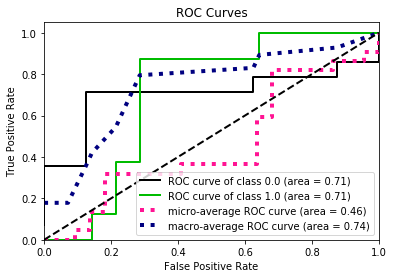

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [40]:
# The usual train-test split mumbo-jumbo
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression

# X, y = sampler.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
nb = LogisticRegression()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, predicted_probas)
plt.show()
print(nb)

In [6]:
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_smote, y_smote = sampler.fit_sample(X, y)

smote_X_minority = np.take(X_smote, np.where(y_smote == 1), axis=0)[0]
smote_y_minority = np.take(y_smote, np.where(y_smote == 1), axis=0)[0]

smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(X_smote, y_smote, train_size=0.8, test_size=0.2, random_state=0, stratify=y_smote)

class_names = ['non-fatal', 'fatal']

In [41]:
import matplotlib.pyplot as plt
import scikitplot as skplt
plt.rc('legend',fontsize=6)

def plot_roc_multiple(X, y, classifiers, name):
    print(classifiers)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for classifier in classifiers:
        clf = classifier
        clf.fit(X_train, y_train)
        predicted_probas = clf.predict_proba(X_test)

        # The magic happens here
        skplt.metrics.plot_roc_curve(y_test, predicted_probas, curves=('macro'))
        plt.show()
#         print(classifier)
#         cv = StratifiedKFold(n_splits=5)

#         tprs = []
#         aucs = []
#         mean_fpr = np.linspace(0, 1, 100)

#         i = 0
#         for train, test in cv.split(X, y):
#             predicted_probas = classifier.fit(X[train], y[train]).predict_proba(X[test])
#             fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#             tprs.append(interp(mean_fpr, fpr, tpr))
#             tprs[-1][0] = 0.0
#             roc_auc = auc(fpr, tpr)
#             aucs.append(roc_auc)
#             plt.plot(fpr, tpr, lw=1, alpha=0.6,
#                      label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#             i += 1

#         mean_tpr = np.mean(tprs, axis=0)
#         mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_auc = np.std(aucs)
#         plt.plot(mean_fpr, mean_tpr, color='b',
#                  label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#                  lw=2, alpha=.8)

#         std_tpr = np.std(tprs, axis=0)
#         tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#         tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#         plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                          label=r'$\pm$ 1 std. dev.')

#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#                  label='Luck', alpha=.8)
  
#     plt.xlim([-0.03, 1.03])
#     plt.ylim([-0.03, 1.03])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve: ' + name)
#     plt.legend(loc="lower right")
#     plt.show()

Let's do Naive Bayes first.
Naive Bayes implements Bayes' Theorem with the caveat that we make a 'naive' assumption of independence. That is, we assume every feature is independent of the others. With the GaussianNB classifier we further assume that the data follows a Gaussian or normal distribution. 

The nice thing about this classifier is that even when it is patently nonsense to assume independence of the features, in practice this often still works well, with uses including spam filtering. Additionally, it is very computationally cheap to train, straightforward to understand, and requires very little tuning apart from setting the 'priors', or the prior class distributions.

After SMOTE we have 34 positives, but let's not hardcode the values of our class priors - let the ratios in the data do the work for us!

[GaussianNB(priors=array([0.38636, 0.61364]))]


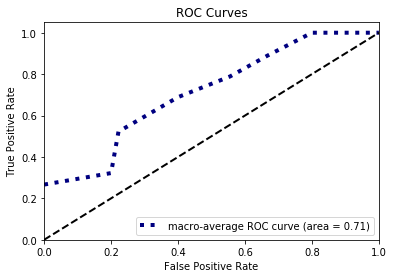

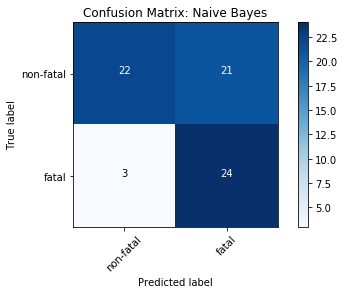

In [42]:
smote_positives_ratio = smote_X_minority.shape[0]/X_smote.shape[0]
smote_negatives_ratio = 1 - smote_positives_ratio

smote_nb_priors = np.array([smote_positives_ratio, smote_negatives_ratio])
naive_bayes_inc_smote_priors = GaussianNB(smote_nb_priors)

plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_inc_smote_priors], "Naïve Bayes")

smote_y_pred = cross_val_predict(naive_bayes_inc_smote_priors, smote_X_train, smote_y_train, cv=StratifiedKFold(n_splits=10))
cnf_matrix = confusion_matrix(smote_y_train, smote_y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix: Naive Bayes', normalize=False)

[GaussianNB(priors=array([0.08475, 0.91525]))]


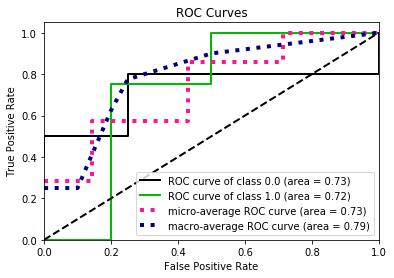

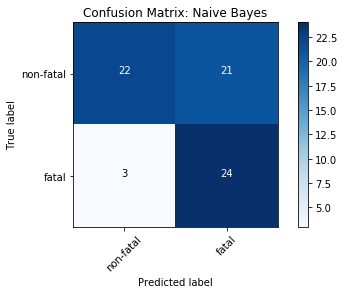

In [13]:
X_minority = np.take(X, positives, axis=0)

original_positives_ratio = X_minority.shape[0]/X.shape[0]
original_negatives_ratio = 1 - original_positives_ratio

original_nb_priors = np.array([original_positives_ratio, original_negatives_ratio])

naive_bayes_wo_priors = GaussianNB(original_nb_priors)

plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_wo_priors], "Naïve Bayes")

smote_y_pred = cross_val_predict(naive_bayes_wo_priors, smote_X_train, smote_y_train, cv=StratifiedKFold(n_splits=10))
cnf_matrix = confusion_matrix(smote_y_train, smote_y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix: Naive Bayes', normalize=False)

The Support Vector Machine (SVM) is another classifier which works by creating a hyperplane that has the largest margin in separating the data. Intuitively, if there is a line with a really big margin, then that implies the model has found a good strategy for classification. We use the various points in the feature space that correspond to our examples as vectors to calculate the margin for the hyperplane, hence the term 'support vectors' because they 'prop up' the hyperplane.

The SVM does have considerably greater scope for tuning than a Naive Bayes classifier, but it is more powerful (due to its being a universal approximator) and makes fewer prior assumptions about the data. Let's see what it can do.

In [14]:
cross_validation = StratifiedKFold(random_state=0, n_splits=10)

svm_parameter_grid = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000], 'gamma':[0.001, 0.01, 0.1, 1]}

balanced_svm = svm.SVC(random_state=0, probability=True, class_weight='balanced')

grid_search = GridSearchCV(balanced_svm, param_grid=svm_parameter_grid, cv=cross_validation, 
                           scoring=make_scorer(f1_score, average='micro'))

grid_search.fit(smote_X_train, smote_y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

balanced_svm = grid_search.best_estimator_
print(balanced_svm)
print(balanced_svm.support_vectors_)

Best score: 0.7142857142857143
Best parameters: {'C': 200, 'gamma': 1, 'kernel': 'poly'}
SVC(C=200, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
[[0.53 0.15 0.07 ... 0.   0.   0.07]
 [0.55 0.16 0.07 ... 0.   0.   0.05]
 [0.59 0.15 0.07 ... 0.   0.   0.05]
 ...
 [0.58 0.14 0.06 ... 0.   0.   0.06]
 [0.57 0.15 0.07 ... 0.   0.   0.05]
 [0.58 0.16 0.07 ... 0.   0.   0.04]]


In [15]:
print(balanced_svm.support_vectors_.shape)

(51, 21)


[GaussianNB(priors=array([0.08475, 0.91525])), SVC(C=200, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)]


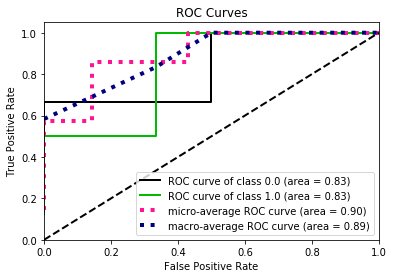

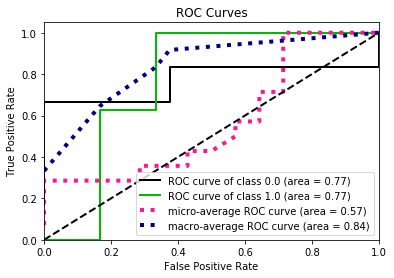

In [16]:
plot_roc_multiple(smote_X_train, smote_y_train, [naive_bayes_wo_priors, balanced_svm], "Naïve Bayes v Support Vector Machine")

Onto decision trees. These classifiers attempt to 'divide and conquer' the data by partitioning it based on the results of a series of binary rules. Those rules that maximise the information gain from dividing the data are made explicit, making the decision tree a white-box model and thus extremely useful in a medical context. They are however prone to overfitting if we aren't careful with the maximum depth. So we will need to pay close attention to that particular parameter.

Best score: 0.9
Best parameters: {'max_depth': 5, 'max_features': 19}


Text(33,0.5,'max_depth')

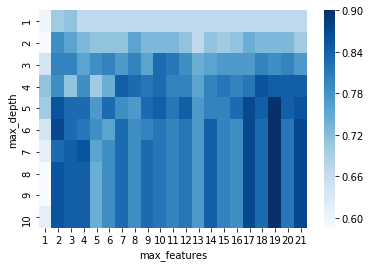

In [17]:
decision_tree_classifier = DecisionTreeClassifier(random_state=0)

parameter_grid = { # 'criterion': ['gini', 'entropy'],
                  # 'splitter': ['best', 'random'],
                  'max_depth': [x+1 for x in range(10)],
                  'max_features': [x+1 for x in range(21)]}

cross_validation = StratifiedKFold(random_state=0, n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(smote_X_train, smote_y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_visualization = []

for grid_pair in grid_search.cv_results_:
    if "mean_test_score" == grid_pair:
        for score in grid_search.cv_results_[grid_pair]:
            grid_visualization.append(score)
    
grid_visualization = np.array(grid_visualization)

grid_visualization.shape = (10, 21)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(21) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(10) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

SVC(C=400, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
F1-score for SVM: 0.63 (+/- 0.56)
F1-score for NB: 0.68 (+/- 0.53)
F1-score for DT-basic: 0.83 (+/- 0.42)
F1-score for DT-adjusted: 0.72 (+/- 0.37)


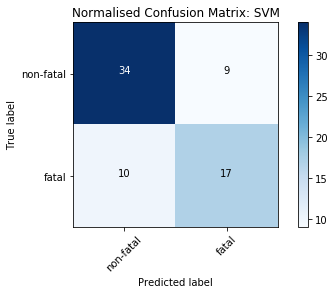

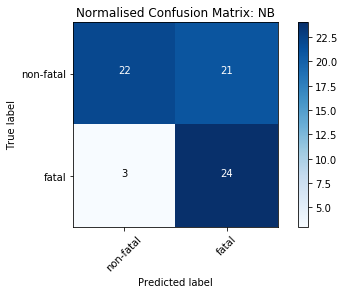

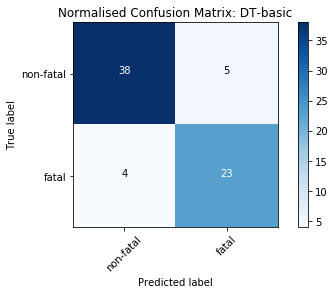

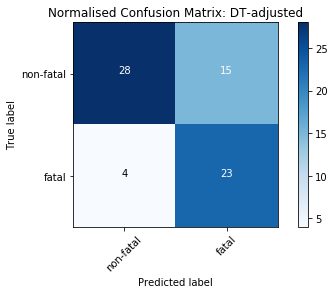

In [20]:
nb_priors = np.array([0.39, 0.61])
svm_params = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000]}

class_names = ['non-fatal', 'fatal']

my_svm = svm.SVC(random_state=0)

classifiers = [GridSearchCV(my_svm, svm_params, refit=True), 
                GaussianNB(nb_priors),
                DecisionTreeClassifier(random_state=0),
                DecisionTreeClassifier(random_state=0, max_depth=3, class_weight='balanced')]
names = ["SVM", "NB", "DT-basic", "DT-adjusted"]

for clf, name in zip(classifiers, names):
    y_pred = cross_val_predict(clf, smote_X_train, smote_y_train, cv=10)
    scores = cross_val_score(clf, smote_X_train, smote_y_train, cv=10, scoring='f1')
    
    if name is "SVM":
        clf.fit(smote_X_train, smote_y_train)
        print(clf.best_estimator_)

    print("F1-score for %s: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))

    cnf_matrix = confusion_matrix(smote_y_train, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalised Confusion Matrix: ' + name, normalize=False)

In [ ]:
import graphviz
from sklearn import tree

my_tree = classifiers[-1]

my_tree.fit(X_res, y_res)

dot_data = tree.export_graphviz(my_tree, out_file=None) 
graph = graphviz.Source(dot_data)

dot_data = tree.export_graphviz(my_tree, out_file=None,
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph
# graph.render("cancer") 

In [ ]:
from sklearn import feature_selection, pre_processing, pipeline

# X = get X
# y = get y

scaler      = pre_processing.FunctionTransformer(norm)
est         = DecisionTreeClassifier(random_state=0)
selector    = feature_selection.RFE(classifier)
my_pipeline = pipeline.Pipeline([('scaler', scaler), ('selector', selector), ('est', est)])

selector = feature_selection.RFE(my_pipeline)
clf = GridSearchCV


# def norm(arr):
#   my_sum = sum(arr)
#   normed_arr = arr / my_sum
#   return normed_arr

# For a given classifier with particular parameter settings:
#   For fold in k folds of cross validation (potentially stratified):
#     let X_fold, y_fold = X, y of the fold of the dataset - which is potentially SMOTEd at the beginning
#     Scale X_fold using our norm function
#     From the scaled data, pick the most informative features using RFE
#     Train the classifier on the preprocessed data
#     Predict, get results for both class-prediction and raw probabilities (former for confusion matrix, 
#                                                                           latter for ROC/PR curves)
# ...
# Evaluate using the acquired class predictions and probabilities - e.g. ROC/PR curves, 
# confusion matrices, probably plot training and validation error rates with plain accuracy metric to 
# detect overfitting or underfitting.